# Theano & Lasagne - A Quick Guide

In this notebook I would like to provide a quick guide through Theano and Lasagne by implementing a DNN-type auto-encoder. This script should be directly runnable, so feel free to adjust any parameters or try any other implementations.

## Environment

Python: 2.7.6

Theano: 0.8.2

Lasagne: 0.1

Required Python packages: numpy, h5py, scikits.audiolab



In [1]:
# import necessary packages

import numpy as np
import theano
import theano.tensor as T
import lasagne
import datetime
import time
import h5py
from scikits.audiolab import wavread, wavwrite
import logging
import matplotlib.pyplot as plt

%matplotlib inline
%env THEANO_FLAGS=floatX=float32

env: THEANO_FLAGS=floatX=float32


/home/yluo/.local/lib/python2.7/site-packages/scikits/audiolab/soundio/play.py:48: UserWarning: Could not import alsa backend; most probably, you did not have alsa headers when building audiolab
  warnings.warn("Could not import alsa backend; most probably, "


You may notice that we set the environment variable `THEANO_FLAGS` here. Of course you can put it in your `theano_rc` file, but I prefer to export that in the notebook.

To use GPU, run:

```python
theano.sandbox.cuda.use('gpu')
```

You can specify which gpu you want to use (if you have more than 1) by using 'gpu0', 'gpu1', etc. The support for multiple GPUs is recently added to Theano, but I'll not discuss it here. And in this script I'll only use CPU.

In [2]:
# set up the logger
# simply copy these codes to any other scripts

logger = logging.getLogger('')
logger.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)

First, we set up the data directory. I've put the example data in the same directory as this script. I've chosen `h5py` to save the data , but you can also use `numpy.save` , `.mat` or anything else for your data.

In [3]:
data_loading = h5py.File('example_data.hdf5')
X = data_loading['input']
X /= np.max(np.abs(X))

This (very) small dataset contains 1000 clips of speech, each with length of 100 frames.

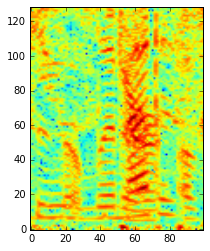

In [4]:
plt.imshow(X[0].T, origin='lower')
plt.show()

We want to build a DNN audo-encoder. Here we set some parameters that will be used. Since here we only have few data, we set the number of hidden units in DNN to be small.

In [5]:
# param

time_dim = 100 # time dimension
freq_dim = 129 # frequency dimension
batch_size = 50 # batch size
learning_rate = 1e-5 # learning rate
nepoch = 50 # number of epoches during training
n_hidden = 128 # number of hidden units in each layer

Our task is to implement an auto-encoder. We first take a look at the basic data structures in Theano.  

Theano is using a graph-based framework. In THeano, all the information are transferred by `Tensors`, and all the `Tensors` are connected throughout a `computation graph`. Our task is to construct the tensors and calculations in the graph, and Theano will arange and execute them for us. 

To create a tensor in the graph, typically we use `theano.tensor.tensor`. For example, here we create a tensor for the input of out network:

In [6]:
input = T.tensor3('input')

We do not need to specify the shape of the tensor. Here, `tensor3` means a 3-D tensor, and `T.matrix` will construct a 2-D tensor (matrix), `T.vector` a 1-D tensor (vector). 

Also, you can specify the data type of the tensor. For example, `T.ftensor3` means a float-type 3-D tensor, `T.ivector3` is an int-type 3-D tensor.

Then we build a 3-layer DNN. Here we'll start to make use of Lasagne, since it provides many useful layers for us to use. We do not need to write our layers from scratch. Here, we need two feed-forward (fully-connected) layers.

But before that, Lasagne requires us to state an input layer which stores the input to the network. You can specify the shape of the input in the statement of input layer if you want, but if you are not sure what will the shape be, you can simply place `None`:

In [7]:
input_shape = (None, time_dim, freq_dim)

Here, the first dimension is the batch size, the second dimension is the time steps in the spectrogram, the last dimension is the frequency range. Setting batch size to `None` allows us to use different batch size during training and testing.

In [8]:
# build a network

layer = lasagne.layers.InputLayer(shape=input_shape)
DNN = {'in': layer} # a dictionary that store the network, 
                    # which is the way I prefered to build the network
    
# since we are building a DNN, we need to first flatten the input into a matrix
layer = lasagne.layers.ReshapeLayer(layer, shape=(-1, [2])) 
# here, (-1, [2]) means to retain dimension 2 (starting from 0) of the input tensor, and
# flatten all the other dimensions into one dimension (which means -1).
# now the input has shape (batch_size*time_dim, freq_dim)

# here I use tanh activation, but you can change it to anything you like
nonlinearity = lasagne.nonlinearities.tanh

# first layer
layer = lasagne.layers.DenseLayer(layer, num_units=n_hidden, nonlinearity=nonlinearity)
# second layer
layer = lasagne.layers.DenseLayer(layer, num_units=n_hidden, nonlinearity=nonlinearity)
# last layer
# notice that the number of hidden units in last layer should be the same 
# with infeat_dim, since we are doing auto-encoding
layer = lasagne.layers.DenseLayer(layer, num_units=freq_dim, nonlinearity=nonlinearity)

# reshape the output back into 3-D tensor

layer = lasagne.layers.ReshapeLayer(layer, shape=(-1, time_dim, [1])) # shape: (batch_size, time_dim, freq_dim)

DNN['out'] = layer

Now we have our network, we need to set up the objective function. Here, we simply use L-2 loss as the objective.

In [9]:
Y = T.tensor3('target')  # shape: (batch_size, time_dim, freq_dim)

# build objective function
def l2_loss(t):
    # Computes half the L2 norm of a tensor without the sqrt
    # loss = sum(t ** 2) / 2
    
    return T.sqr(t - Y).sum() / 2

And then we need to get the output of the network to calculate the loss. Lasagne provides a function `lasagne.layers.get_output` that allows us to get the output of the network easily:

In [10]:
# get the output of the network
net_output_train = lasagne.layers.get_output(DNN['out'], {DNN['in']: input}, deterministic=False)
net_output_test = lasagne.layers.get_output(DNN['out'], {DNN['in']: input}, deterministic=True)

You may notice that here, I defined to variable for training and testing respectively. The difference is `deterministic`. This parameter is used to control different phase of your experiment. Sometimes we use some regularization techniques such as Dropout, adding noise, etc. to make our network more robust during training time, but when testing those thing should be closed. Setting `deterministic=False` means that the network is in training phase, and all the tricks are enabled; setting it to `True` means that we are testing the network now, and all those stuffs need to be closed. Although we are not using anything that differs in training and testing here, I recommend that you always set two parameters like that in case you forget something.

In [11]:
# objective for training and testing
obj_train = l2_loss(net_output_train)
obj_test = l2_loss(net_output_test)

And we need to set a learning algorithm for our network. Here we simply use the most common stochastic gradient descend (with momentum, which will allows it to be more robust).

In [12]:
# get all the parameters that are traininable
all_params = lasagne.layers.get_all_params(DNN['out'], trainable=True)

# apply sgd to those params respect to training objective
updates = lasagne.updates.momentum(obj_train, all_params, 
                                   learning_rate=learning_rate, 
                                   momentum=0.9)

And now we can build the training and testing operations in the computation graph. In Theano, we need to build functions using `theano.function`. This will compile the operations into functions that could be executed by Theano.

In [13]:
# the training operation
# during training, we need to pass the parameter `updates`

# the first parameter ([input, Y, lr]) is the list of all the parameters
# needed by the operation, the second parameter (obj_train) is the output 
# of the operation
train = theano.function([input, Y], obj_train, updates=updates)

# during testing, we simply need to specify the inputs to the operation
calculate_loss = theano.function([input, Y], obj_test)

# and we also want to get the output of the network
get_output = theano.function([input], net_output_test)

And finally, we can train the network. When training a network, to randomly shuffle the input data is always a good choice. Hence here we shuffle the data in each batch (unfortunately Lasagne does not provide functions to do this):

In [14]:
logger.info("Start training...\n")
for i in range(nepoch):
    start_time = time.time()
    # in each epoch, first shuffle the data
    shuffle_index = np.random.choice(X.shape[0], X.shape[0], replace=False)
    
    cost_train = 0.
    for j in xrange(0, X.shape[0], batch_size):
        current_index = sorted(shuffle_index[j:j+batch_size])
        current_input = X[current_index]
        current_target = current_input # audo-encoding the input to itself
        
        # run an training operation
        cost_train += train(current_input, current_target) / X.shape[0]
    
    logger.info("Epoch {} took {}, training cost = {}\n".format(
            i+1, time.time() - start_time, cost_train))

Start training...

Epoch 1 took 18.3933649063, training cost = 181.145903916

Epoch 2 took 20.7372291088, training cost = 71.7564628082

Epoch 3 took 17.76968503, training cost = 49.5297204524

Epoch 4 took 18.8208200932, training cost = 40.1039158495

Epoch 5 took 26.3262178898, training cost = 34.359749857

Epoch 6 took 21.4514610767, training cost = 30.2120481712

Epoch 7 took 21.8368699551, training cost = 26.9953481936

Epoch 8 took 21.5649580956, training cost = 24.3917884286

Epoch 9 took 16.9866938591, training cost = 22.2314873029

Epoch 10 took 15.0297498703, training cost = 20.4156444656

Epoch 11 took 21.969960928, training cost = 18.8609719115

Epoch 12 took 22.5754480362, training cost = 17.5266782512

Epoch 13 took 20.9770691395, training cost = 16.3578004164

Epoch 14 took 16.397495985, training cost = 15.3270734718

Epoch 15 took 26.3900868893, training cost = 14.412453426

Epoch 16 took 20.7804639339, training cost = 13.5902215963

Epoch 17 took 21.7260279655, trainin

Let's see the output for one utterance.

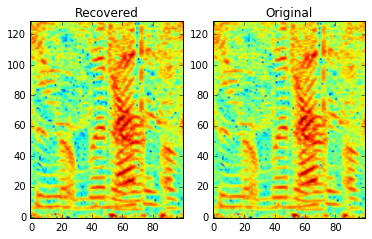

In [21]:
current_output = get_output(X[:1])
plt.subplot(121)
plt.imshow(current_output[0].T, origin='lower')
plt.title('Recovered')
plt.subplot(122)
plt.imshow(X[0].T, origin='lower')
plt.title('Original')
plt.show()

The performance is pretty good. You can also try different number of layers, number of hidden units in each layer, nonlinearity (activation) function, learning algorithm (I recommend RMSprop and ADAM), learning rate, target, etc. Enjoy!